In [ ]:
#| default_exp baselines

In [ ]:
#| export
import numpy as np
import ruptures as rpt
from fastcore.all import *
from scipy.spatial import ConvexHull
from fastai.torch_core import Tensor, tensor

# Diffusion properties

The diffusion properties of a particle are capture in its mean squared displacement (MSD) $\langle x^2\rangle = 2d Dt^\alpha$, where $d$ is the dimension, $D$ is the diffusion coefficient and $\alpha$ is the anomalous diffusion exponent. A common technique to study single-particle diffusion is to estimate the MSD with the time-averaged mean squared displacement (TA-MSD).

In [ ]:
#| export
def tamsd(
    x:Tensor,  # Input trajectory of shape [length, dim]
    dt:int=1   # t-lag: time interval to compute displacements
    )-> float:
    "Time-averaged mean squared displacement of a trajectory `x` in `dt` intervals."
    return (x[dt:] - x[:-dt]).pow(2).sum(-1).mean()


From the TA-MSD, we can compute both $D$ and $\alpha$ looking at its scaling with $t$. In Brownian motion, we can extract the diffusion coefficient through a linear fit of the TA-MSD $\propto 2dDt$ over time, as the slope is $2dD$. In anomalous diffusion, we can perform a linear fit in logarithmic space, since it follows a power-law TA-MSD $\propto t^\alpha$.

In [ ]:
#| export
def diffusion_coefficient_tamsd(
    x:Tensor,                # Input trajectory of shape [length, dim]  
    t_lag:Iterable=[2, 3, 4] # t-lags to consider for the fit
    )->float:                # Diffusion coefficient
    "Estimates the diffusion coefficient fitting the `tmsd` for different `dt`."
    tmsds = [tamsd(x, dt) for dt in t_lag]
    D = np.polyfit(t_lag, tmsds, 1)[0]
    return D/(2*x.shape[-1])

def anomalous_exponent_tamsd(
    x:Tensor,         # Input trajectory of shape [length, dim]
    t_lag:Iterable=[] # t-lags to consider. Defautls to [2,...,max(5, 10% length)]
    )->float:         # Anomalous exponent
    "Estimates the anomalous exponent fitting the `tmsd` in log-log scale for different t-lags."
    if len(t_lag) == 0: t_lag = np.arange(2, max(5, int(0.1*x.shape[0])))
    tmsds = [tamsd(x, dt) for dt in t_lag]
    return np.polyfit(np.log(t_lag), np.log(tmsds), 1)[0]

Let's see an example with Brownian motion. First, with our `brownian_motion` function, we can simulate a few trajectories with different diffusion coefficients.

In [ ]:
#| hide
from step.data import brownian_motion

In [ ]:
max_t = 10000
Ds = np.array([0.5, 1., 5., 20])[:, None, None] # Extra dimensions to broadcast
dim = 2

np.random.seed(7)
trajs = tensor(brownian_motion(len(Ds), max_t, Ds, dim=dim))

Let's compute the diffusion coefficients for the trajectories.

In [ ]:
[diffusion_coefficient_tamsd(traj.T) for traj in trajs]

[0.5010303556919097, 0.9403451681137086, 4.982022762298584, 19.222974777221676]

We can do a similar analysis for anomalous diffusion. Let's use the [andi_datasets]() library to generate a few fractional brownian motion trajectories with different $\alpha$.

In [ ]:
#| hide
from andi_datasets.datasets_theory import datasets_theory

In [ ]:
ad = datasets_theory()
alphas = [0.1, 0.5, 1., 1.5]
np.random.seed(7)
trajs = ad.create_dataset(T=max_t, N_models=1, exponents=alphas,
                          models=[2], dimension=dim)
trajs = tensor(trajs[:, 2:]).reshape(len(alphas), max_t, dim)

In [ ]:
[anomalous_exponent_tamsd(traj) for traj in trajs]

[0.1301758215732175,
 0.47395024375992173,
 0.9880268080088149,
 1.4136567214095137]

# Changepoint detection methods
## Local convex hull method

The [local convex hull method](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.96.022144) allows us to detect changepoints between two diffusive states in a trajectory. However, it does not provide any information about the properties of the segments.

In [ ]:
#| export
def hull_diameter(hull):
    "Diameter of the local convex hull."
    max_diff = hull.max_bound - hull.min_bound
    return np.sqrt(np.dot(max_diff, max_diff))

In [ ]:
#| export
def convex_hull_cp(
    traj:np.ndarray,    # Trajectory to study
    tau:int=10,         # Size of the sliding window
    method:str="volume" # Property of interest: "volume" or "diameter"
    )->np.ndarray:      # Changepoints along the trajectory
    "Detect the changepoints in `traj` with the local convex hull method."
    if (method != "volume") and (method != "diameter"):
        raise ValueError(f"Invalid method {method}, it should be either 'volume' or 'diameter'.")
    max_t = traj.shape[0] - 2*tau
    S = np.zeros(max_t)
    hull_prop = hull_diameter if method == "diameter" else lambda x: x.volume
    for t in range(max_t):   
        hull = ConvexHull(traj[t:(t+2*tau)])
        S[t] = hull_prop(hull)
    S -= S.mean()
    return np.argwhere(S[1:]*S[:-1] < 0)
    

This method relies on computing properties of the local convex hull conformed by a set of $\tau$ points along a trajectory. Whenever we encounter large changes in these properties, it signals a change in the diffusion mode. We typically consider the volume or the diameter of the hull.

To identify the changes, the method relies on a simple heuristic: we compute the mean of the property of interest along the trajectory and we mark a changepoint whenever we cross the mean value.

Let's see an example with a trajectory. We consider a 2D Brownian motion trajectory with two diffusive modes: a slow and a fast one. To simulate the fast one, we multiply the trajectory displacements by a factor $\gt1$, effectively increasing the diffusion coefficient by its square. 

In [ ]:
T = 1000
cps = np.array([400, 600])

np.random.seed(7)
traj = np.random.randn(T, 2)
traj[slice(*cps)] = 2.5*traj[slice(*cps)] # 2.5x factor displacements between cps
traj = traj.cumsum(0)

The resulting trajectory has two changepoints in which we switch from slow to fast and fast to slow, respectively.

To build some intuition about convex hulls, let's look at the local convex hull of the first 10 points of the trajectory.

In [ ]:
points = traj[:10]
hull = ConvexHull(points)

In [ ]:
#| hide
import matplotlib.pyplot as plt

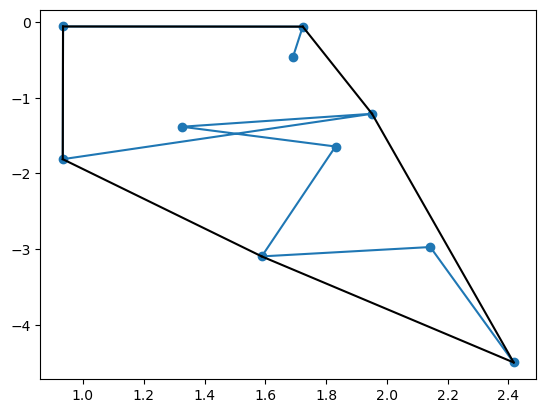

In [ ]:
#| code-fold: true
plt.plot(hull.points[:, 0], hull.points[:, 1], 'o-')
for simplex in hull.simplices:
    plt.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'k-')

To distinguish between both diffusive states, we compute the local convex hull properties (diameter and volume) over a sliding window of size $\tau$ along the trajectories.

In [ ]:
tau = 10
max_t = traj.shape[0] - 2*tau
Sd = np.zeros(max_t)
Sv = np.zeros(max_t)

for k in range(max_t):   
    hull = ConvexHull(traj[k:(k+2*tau)])
    Sd[k] = hull_diameter(hull)
    Sv[k] = hull.volume

This allows us to extract the changepoints by looking at the points where the diameter or volume over time cross their mean value over time. This is what we do to find the changepoints in `convex_hull_cp`.

In [ ]:

changepoints_vol = convex_hull_cp(traj, tau=tau, method="volume")
changepoints_diam = convex_hull_cp(traj, tau=tau, method="diameter")
    

In the figures below, we see all the information together. The changepoints (red dots) are always marked in the time-step prior to crossing the mean-value line.

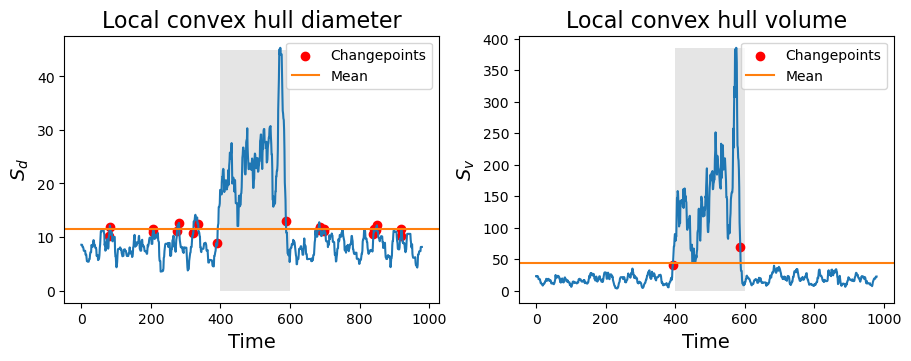

In [ ]:
#| code-fold: true
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), constrained_layout=True)
axes[0].plot(Sd)
axes[0].scatter(changepoints_diam, Sd[changepoints_diam], c='r', label="Changepoints")
axes[0].axhline(Sd.mean(), label='Mean', c='C1')
axes[0].legend()
axes[0].fill_betweenx(np.arange(Sd.max()), on, off, zorder=-1, alpha=0.1, color='k', lw=0)
axes[0].set_xlabel('Time', fontsize=14); axes[0].set_ylabel(r'$S_d$', fontsize=14)
axes[0].set_title("Local convex hull diameter", fontsize=16)

axes[1].plot(Sv)
axes[1].scatter(changepoints_vol, Sv[changepoints_vol], c='r', label="Changepoints")
axes[1].axhline(Sv.mean(), label='Mean', c='C1')
axes[1].legend()
axes[1].fill_betweenx(np.arange(Sv.max()), on, off, zorder=-1, alpha=0.1, color='k', lw=0)
axes[1].set_xlabel('Time', fontsize=14); axes[1].set_ylabel(r'$S_v$', fontsize=14)
axes[1].set_title("Local convex hull volume", fontsize=16);

## Ruptures

The [ruptures library](https://centre-borelli.github.io/ruptures-docs/) implements a kernel change point detection algorithm (see their [review paper](8https://www.sciencedirect.com/science/article/abs/pii/S0165168419303494?via%3Dihub)) performing a piecewise constant fit of the input signal.

The algorithm can either take a fixed number of changepoints to allocate, or infer the number by balancing the accuracy of the fit with a penalty for adding new changepoints. In most of our applications, we do not know the number of changepoints beforehand (which is the beauty of [STEP](https://arxiv.org/abs/2302.00410)!).

In [ ]:
#| export
@delegates(rpt.KernelCPD)
def ruptures_cp(
    x:np.ndarray,  # Input signal with shape [length, dim]
    pen:float=1.,  # Penalty for the changepoint prediction
    **kwargs
    )->np.ndarray: # Changepoints along the trajectory
    "Returns the change points of signal `x`, excluding the initial and final times."
    alg = rpt.KernelCPD(**kwargs).fit(x)
    return alg.predict(pen=pen)[:-1]

This algorithm is particularly well-suited to post-process our model predictions, which are (quasi) pointwise constant. Furthermore, unlike the local convex hull method, it is not limited to just two "states".

Let's see an example of what could be a typical application of `ruptures_cp`. First, we will create a synthetic model prediction with some noise.

In [ ]:
max_t = 250
cps = [20, 70, 150]
values = [-1., 3., 1., 2.]

np.random.seed(7)
pred = np.concatenate([[v]*(c1 - c0) for v, c0, c1 in zip(values, [0]+cps, cps+[max_t])])
pred += 0.5*np.random.randn(*pred.shape)

Now let's perform the changepoint detection over this noisy prediction considering different penalties.

In [ ]:
penalties = [1, 2, 5, 100]
cps_pens = [ruptures_cp(pred, pen=pen) for pen in penalties]

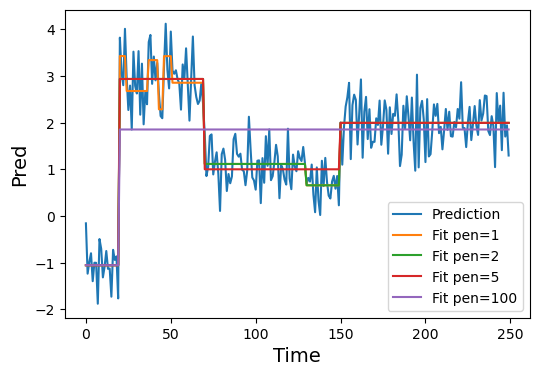

In [ ]:
#| code-fold: true
plt.figure(figsize=(6, 4))
plt.plot(pred, label="Prediction")
for pen, cp in zip(penalties, cps_pens):
    segment_fit = [[pred[c0:c1].mean()]*(c1-c0) for c0, c1 in zip([0]+cp, cp+[max_t])]
    plt.plot(np.concatenate(segment_fit), label=f"Fit pen={pen}")
plt.legend()
plt.xlabel("Time", fontsize=14)
plt.ylabel("Pred", fontsize=14);

For this case, a penalty of $5$ is just right to recover the ground truth value of our signal. However, if we didn't know the ground truth beforehand, a penalty of $2$ would also provide a reasonable result. 